# Análisis Exploratorio de Datos – Fuentes UNID

En este notebook se realiza un análisis exploratorio de las fuentes no identificadas (UNIDs) contenidas en el archivo `unids_3F_beta_err_names.txt`. Estas fuentes no cuentan con una etiqueta de clase conocida (a diferencia de los datos ASTRO o DM simulados), pero se espera que puedan incluir candidatas a materia oscura.

Cada instancia incluye las siguientes variables:

- **E_peak**: Energía pico (sin logaritmar).
- **beta**: Curvatura espectral.
- **sigma_det**: Significancia de detección.
- **beta_Rel**: Error relativo sobre la curvatura.
- **number**: Identificador único de cada fuente.

Este análisis busca comprender la distribución de estas variables, detectar patrones, posibles agrupaciones o comportamientos atípicos que puedan indicar candidatos interesantes para detección de anomalías con modelos no supervisados como One-Class SVM.

In [48]:
import pandas as pd
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Definir nombres de las columnas
features = ['E_peak', 'beta', 'sigma_det', 'beta_Rel', 'number']

# Cargar los datos
unids_df = pd.read_csv('../../data/raw/unids_3F_beta_err_names.txt', sep="\s+", names=features, engine='python', skiprows=1)

In [49]:
# Ver muestra
unids_df.head()

,E_peak,beta,sigma_det,beta_Rel,number
0,2.51290,0.0897,7.3996,1.630992,0
1,1.47820,0.4163,5.4150,0.770838,1
2,1.59640,0.6783,10.7909,0.371222,2
3,0.93095,0.2771,7.6056,0.628654,3
4,0.44480,0.3207,4.2748,0.567509,4


## Descripción y estadísticas

In [50]:
unids_df.describe()

,E_peak,beta,sigma_det,beta_Rel,number
count,1125.000000,1125.000000,1125.000000,1125.000000,1125.000000
mean,6.035556,0.347647,8.310279,0.936490,562.000000
std,89.583292,0.236009,5.601328,2.808888,324.903832
min,0.000002,0.002400,4.055600,0.000900,0.000000
25%,0.376570,0.159000,5.117300,0.362970,281.000000
50%,0.811710,0.305800,6.509900,0.547970,562.000000
75%,1.702900,0.493200,9.208800,0.889688,843.000000
max,2950.500000,1.000000,50.308300,74.954225,1124.000000


In [51]:
unids_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1125 entries, 0 to 1124
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   E_peak     1125 non-null   float64
 1   beta       1125 non-null   float64
 2   sigma_det  1125 non-null   float64
 3   beta_Rel   1125 non-null   float64
 4   number     1125 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 44.1 KB


## 📊 Histogramas de cada variable (feature)

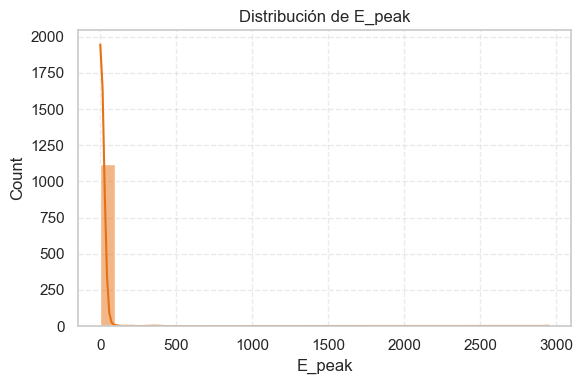

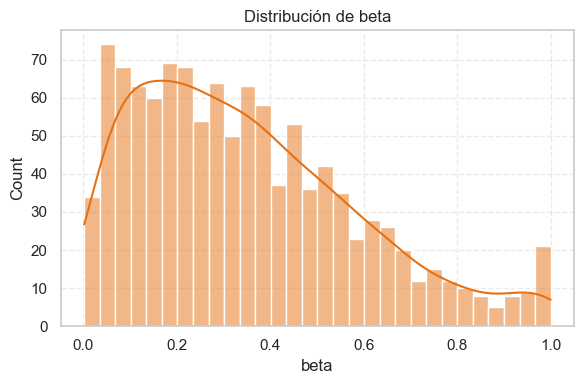

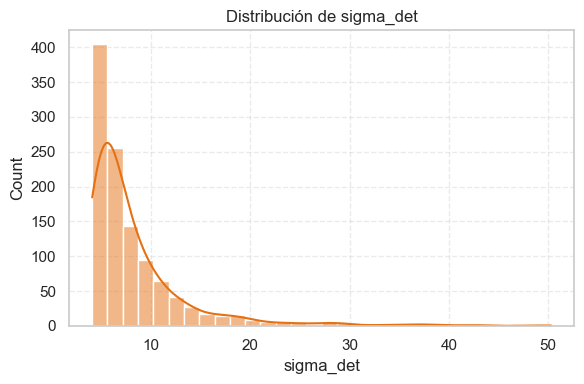

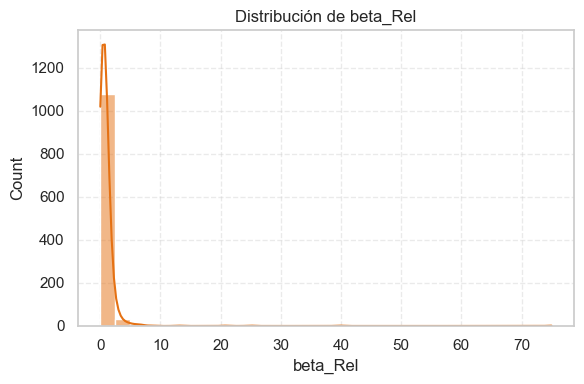

In [52]:
sns.set(style="whitegrid")

for col in ['E_peak', 'beta', 'sigma_det', 'beta_Rel']:
    plt.figure(figsize=(6, 4))
    sns.histplot(unids_df[col], kde=True, bins=30, color='#e57113')
    plt.title(f'Distribución de {col}')
    plt.xlabel(col)
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

## 📊 Correlaciones

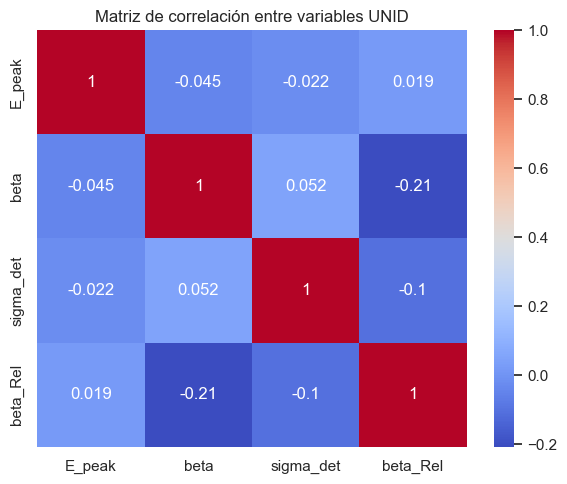

In [53]:
plt.figure(figsize=(6, 5))
sns.heatmap(unids_df[['E_peak', 'beta', 'sigma_det', 'beta_Rel']].corr(), annot=True, cmap='coolwarm')
plt.title('Matriz de correlación entre variables UNID')
plt.tight_layout()
plt.show()

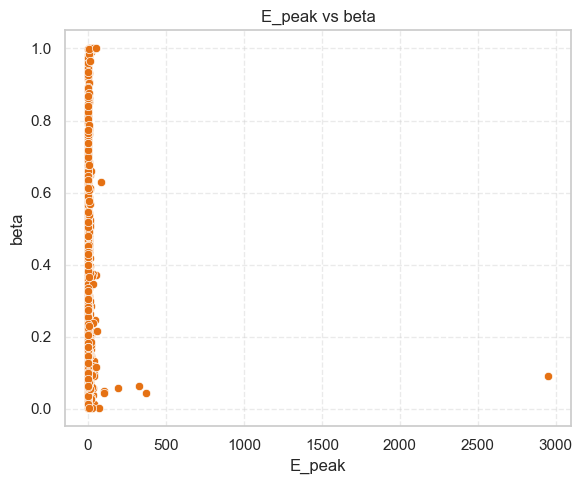

In [54]:
# Scatter pot de E_peak vs beta
plt.figure(figsize=(6, 5))
sns.scatterplot(data=unids_df, x='E_peak', y='beta', color='#e57113')
plt.title('E_peak vs beta')
plt.xlabel('E_peak')
plt.ylabel('beta')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

In [55]:
# Convertir las columnas a logaritmo de base 10
unids_df['E_peak'] = np.log10(unids_df['E_peak'])
unids_df['beta'] = np.log10(unids_df['beta'])
unids_df['sigma_det'] = np.log10(unids_df['sigma_det'])
unids_df['beta_Rel'] = np.log10(unids_df['beta_Rel'])
# Ver muestra
unids_df.head()

,E_peak,beta,sigma_det,beta_Rel,number
0,0.400175,-1.047208,0.869208,0.212452,0
1,0.169733,-0.380594,0.733598,-0.113037,1
2,0.203142,-0.168578,1.033058,-0.430366,2
3,-0.031074,-0.557363,0.881133,-0.201588,3
4,-0.351835,-0.493901,0.630916,-0.246028,4


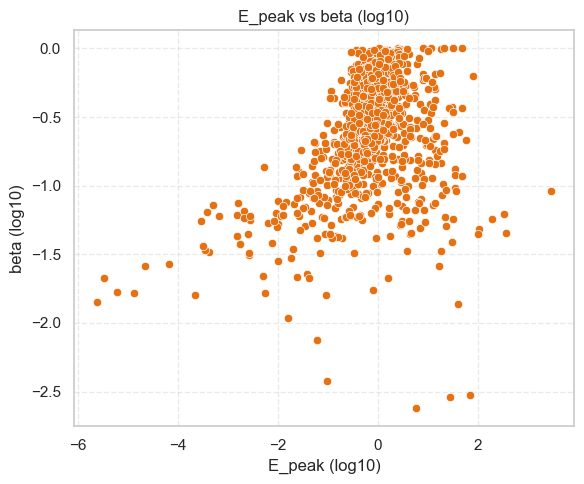

In [56]:
# Scatter plot de unids E_peak vs beta
plt.figure(figsize=(6, 5))
sns.scatterplot(data=unids_df, x='E_peak', y='beta', color='#e57113')
plt.title('E_peak vs beta (log10)')
plt.xlabel('E_peak (log10)')
plt.ylabel('beta (log10)')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


## Observaciones del Análisis Exploratorio (EDA) – Fuentes UNID

A continuación se detallan los principales hallazgos obtenidos del análisis de las variables contenidas en las fuentes no identificadas (UNIDs):

### Distribuciones de variables
- **E_peak** presenta una fuerte asimetría positiva (cola larga), con la mayoría de valores muy concentrados por debajo de 100, pero con valores extremos que superan los 1000. Esto sugiere la presencia de posibles outliers o escalas diferentes de emisión en algunas fuentes.
- **beta** muestra una distribución sesgada hacia valores bajos, con una concentración destacada entre 0.0 y 0.4. Este patrón puede estar asociado a formas espectrales más típicas, mientras que valores mayores podrían representar fuentes más inusuales.
- **beta_Rel** y **sigma_det** también muestran colas largas, lo que indica variabilidad en la calidad o fiabilidad de las mediciones espectrales.
- La transformación logarítmica de estas variables ayuda a **reducir la asimetría y comprimir outliers**, como se evidencia en la última figura (`log10(E_peak)` vs `log10(beta)`).

### Correlación entre variables
- El mapa de correlación muestra **correlaciones débiles** entre las variables (`|r| < 0.25`), lo que sugiere que estas características aportan información relativamente independiente.
- La variable `beta_Rel` está moderadamente correlacionada negativamente con `beta`, lo que podría indicar que la curvatura espectral más baja tiende a estar mejor caracterizada.

### Relaciones bivariadas
- El scatter plot `E_peak` vs `beta` evidencia **grandes concentraciones en regiones específicas del espacio**, pero también algunos puntos claramente aislados (posibles candidatos a anomalía).
- Al aplicar la escala logarítmica (`log10`), se observa un **grupo denso bien delimitado** junto con varios puntos alejados, lo que refuerza la necesidad de utilizar un modelo de detección de anomalías.

---

## Conclusión

Los datos de las fuentes UNID presentan una alta variabilidad en sus características espectrales, así como valores extremos que podrían indicar fenómenos no convencionales. Esta exploración apoya el uso de modelos de aprendizaje no supervisado, como **One-Class SVM**, para identificar observaciones que se desvíen significativamente del comportamiento de fuentes astrofísicas conocidas.
